In [1]:
import pandas as pd, numpy as np
import os
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse
from ResearchML import *
from mlfinlab.microstructural_features import *
from mlfinlab.sample_weights import *
from sklearn.ensemble import RandomForestClassifier

workPath = "/home/xetra/AlphaGoldmine/Data/"
future = "CL"
y = 2018

contFuture = os.path.join(workPath, future.lower(), f"{future}Cont")
contFutureMLOLD = os.path.join(workPath, future.lower(), f"{future}ContML")

vbPath = os.path.join(workPath, future.lower(), f"{future}ContVB")
contFutureLevelBucketsVB = os.path.join(workPath,future.lower(), f"{future}ContLevelBuckets")
vpDir = os.path.join(workPath,future.lower(),"VP")

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [139]:
df=pd.read_feather(contFuture).set_index("date")

In [3]:
# get VolumeBars
from tqdm import tqdm
def getGroupbyIndex(s, m=1000):
    ts, tmp, idx = 0, 0, []
    for v in tqdm(s):
        ts+=v
        idx.append(tmp)
        if ts >= m: 
            ts = 0
            tmp+=1
    return idx

def getVolumeBars(df,vol,suffix,thr=1000,how={"o":"first","h":"max","l":"min","c":"last","vol":"sum","nrT":"sum","bidVol":"sum","askVol":"sum","date":"first"}):
    temp = getGroupbyIndex(df[vol], m=thr)
    print(f"Getting {len(set(temp))} VolumeBars from {len(df)} entries")
    df["temp"] = temp
    vb = df.groupby("temp").agg(how).add_suffix(suffix)
    return vb.reset_index(drop=True).rename(columns={"dateVb":"date"}).set_index("date")

In [4]:
df = df.reset_index()

In [5]:
vb=getVolumeBars(df,"vol","",thr=5000)

100%|██████████| 3821312/3821312 [00:01<00:00, 2049028.43it/s]
Getting 170157 VolumeBars from 3821312 entries


## getting non negative rolled price

In [38]:
def getNonNegRolledPrice(df,ohlc=["o","h","l","c"],cols={"contract":"contract","open":"o","close":"c"}):
    rolled = df[ohlc].copy(deep=True)
    rolled["returns"] = rolled[cols["close"]].diff()/df[cols["close"]].shift(1)
    return (1+rolled["returns"]).cumprod().rename("rPrices")

In [56]:
vb["rPrices"] = getNonNegRolledPrice(vb)

<AxesSubplot:title={'center':'Bars Per Day, min:1, mean:50'}>

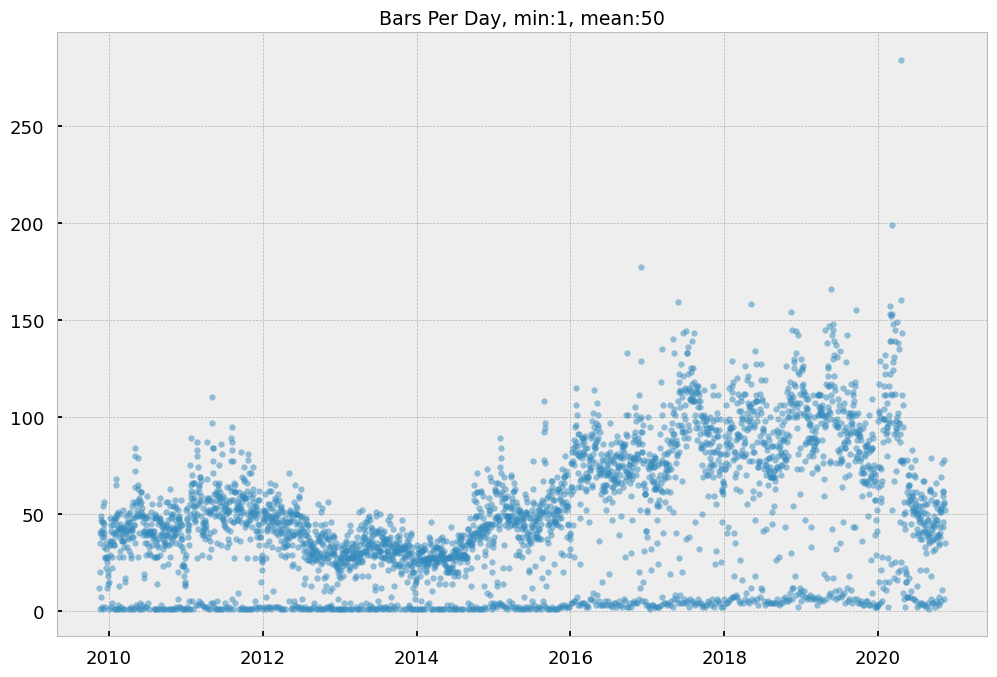

In [121]:
tmp=vb["c"].groupby(vb.index.date).count()
tmp.plot(title=f"Bars Per Day, min:{tmp.min()}, mean:{int(tmp.mean())}",style=".",alpha=.5)

# Get OHLCV Features

In [42]:
def getVWAP(hlc,v,span=1000):
    p = hlc.mean(axis=1)
    return (p*v).rolling(window=span,min_periods=1).sum() / v.rolling(window=span,min_periods=1).sum()
def stDevVW(hlc,v,span=1000):
    return getVWAP(hlc,v,span).rolling(window=span,min_periods=1).std()
def orderFlowImbalance(ohlcv,span=1000,df=0.25,std=stDevVW):
    import scipy
    z = (ohlcv[list(ohlcv)[3]]-ohlcv[list(ohlcv)[0]])/std(ohlcv[list(ohlcv)[1:-1]],ohlcv[list(ohlcv)[-1]])
    z = scipy.stats.t.cdf(z,df)
    return ((ohlcv[list(ohlcv)[-1]]*z-ohlcv[list(ohlcv)[-1]]*(1-z))/ohlcv[list(ohlcv)[-1]]).rename("OFI")

def CVD(bidAsk):
    bidAsk["del"]=bidAsk[bidAsk.columns[1]]-bidAsk[bidAsk.columns[0]]
    for d in tqdm(set(bidAsk.index.date)): bidAsk.loc[bidAsk.index.date==d,"CVD"]=bidAsk.loc[bidAsk.index.date==d,"del"].cumsum()
    return bidAsk["CVD"]

def relCVD(c,o,cvd,rplInf=0):
    return pd.Series((c/o-1)/cvd).replace([np.inf,-np.inf],rplInf).rename("relCVD")

In [43]:
window=1000
span=1000

In [44]:
from mlfinlab.microstructural_features import *
vb["OFI"] = orderFlowImbalance(vb[["o","h","l","c","vol"]],span=1000)
vb["RollImpact"] = get_roll_impact(vb.c,vb.c*vb.vol,window=window)
vb["SpreadEst"] = get_corwin_schultz_estimator(vb.h,vb.l,window=window)
vb["vola"] = get_bekker_parkinson_vol(vb.h,vb.l,window=window)
vb["KylesLambda"] = get_bar_based_kyle_lambda(vb.c,vb.vol,window=window)
vb["AmihudLambda"] = get_bar_based_amihud_lambda(vb.c,vb.c*vb.vol,window=window)
vb["hasbroukLambda"] = get_bar_based_hasbrouck_lambda(vb.c,vb.c*vb.vol,window=window)
vb["VPIN"] = get_vpin(vb.c, vb.askVol,window=window)
vb["CVD"] = relCVD(vb.c,vb.o,CVD(vb[["bidVol","askVol"]]))

<ipython-input-42-d31cb2eb7ace>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bidAsk["del"]=bidAsk[bidAsk.columns[1]]-bidAsk[bidAsk.columns[0]]
  0%|          | 0/3380 [00:00<?, ?it/s]/home/xetra/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/xetra/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a co

## get Level Buckets

In [155]:
bucketsPath = os.path.join(workPath, future.lower(), f"{future}Buckets")

In [156]:
buckets = pd.read_feather(bucketsPath)

In [157]:
buckets=buckets.dropna()

In [158]:
buckets = buckets.set_index("date")

In [160]:
def bucketsOnLevels(b,priceAndLevel):
    cols = list(priceAndLevel)
    def applyBuckets(row):
        nonlocal b, cols
        lBand = row[cols[1]]-row[cols[1]]*b
        hBand = row[cols[1]]+row[cols[1]]*b
        if lBand <= row[cols[0]] <= hBand: return 1
        else: return 0
    return priceAndLevel.apply(applyBuckets,axis=1).rename(cols[1]+"B")

In [161]:
frames = []
price = vb[["h","l","c"]].mean(axis=1).rename("price")
b = np.log(price).rolling(window=span,min_periods=1).std().quantile(.5)
for c in buckets.columns:
    frames.append(bucketsOnLevels(b,pd.merge(price, buckets[c], right_index=True, left_index=True)))
df = pd.concat([df,pd.concat(frames, axis=1)],axis=1)

In [169]:
buckets=df[['o1DB', 'h1DB', 'l1DB', 'c1DB', 'retrDB', 'o1WB', 'h1WB',
       'l1WB', 'c1WB', 'retrWB', 'o1MB', 'h1MB', 'l1MB', 'c1MB', 'retrMB']]

In [174]:
vb = pd.concat([vb,buckets.loc[vb.index]],axis=1)

## get Events Features

# Define Target

In [45]:
from mlfinlab.labeling import *
from mlfinlab.util import *
t1=add_vertical_barrier(vb.index,vb.rPrices,num_days=20)
trgt=get_daily_vol(vb.rPrices,span)

## Set ptsl
Set `ptsl=[4,4]` because, i am looking for big returns within 20 days/ 4 weeks. The graph below, you see equivalence between weekly returns and targets.

In [115]:
ptsl=[4,4]

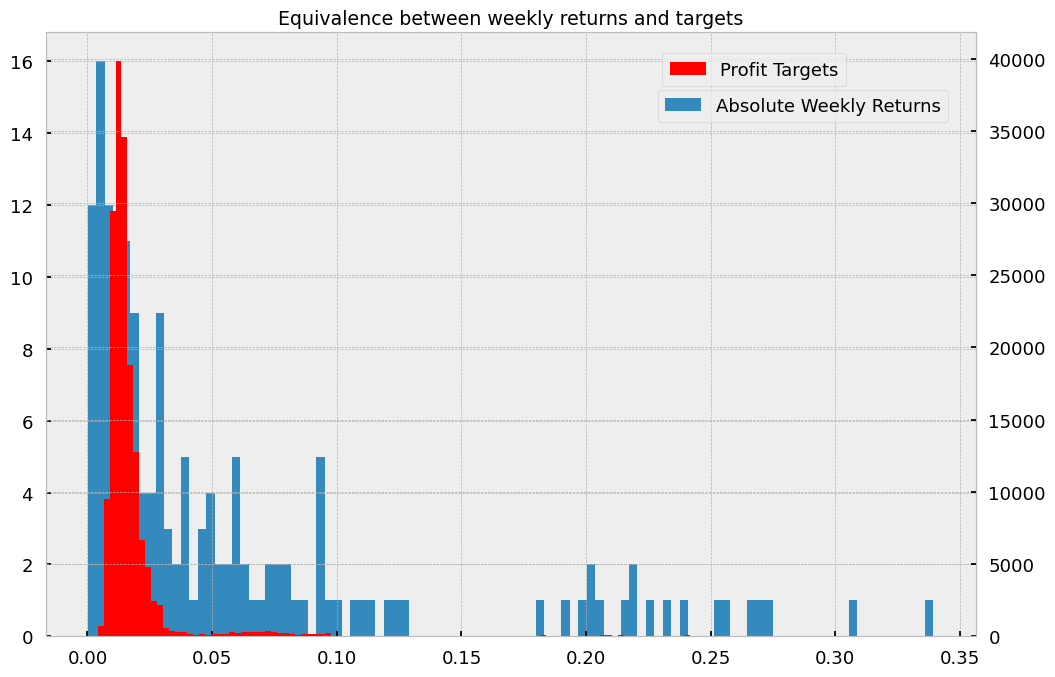

In [189]:
_,ax=plt.subplots()
ax.set_title("Equivalence between weekly returns and targets")
ax.hist(abs(vb.rPrices.pct_change(1,freq="W")), bins=100, label="Absolute Weekly Returns")
ax1=ax.twinx()
ax1.hist(trgt, color="r", bins=100, label="Profit Targets")
ax.legend(ncol=1,bbox_to_anchor=(.98,.92))
ax1.legend(ncol=1,bbox_to_anchor=(.87,.98))
plt.show()

## get labels

In [194]:
eventsPath=f"eventsMomentum-vol{span}-window{window}"
if os.path.exists(eventsPath): events=pd.read_feather(eventsPath).set_index("date")
else: 
    events=get_events(
                        close=vb.rPrices,
                        t_events=vb.index,
                        pt_sl=ptsl,
                        target=trgt,
                        min_ret=trgt.quantile(0.1),
                        num_threads=12,
                        vertical_barrier_times=t1,
                        side_prediction=None,
                        verbose=True)
    events.reset_index().to_feather(eventsPath)
out=get_bins(events,vb.rPrices)

2021-03-24 19:17:05.952180 100.0% apply_pt_sl_on_t1 done after 0.5 minutes. Remaining 0.0 minutes.


In [204]:
out.bin.value_counts()

 0    92383
-1    46988
 1    13330
Name: bin, dtype: int64

In [205]:
### cut out zeros, there was not enough momentum
out = out[out.bin != 0]
events = events.loc[out.index]
vb = vb.loc[out.index]

## get weights to penalize overlapping labels

In [211]:
w = get_weights_by_return(events.dropna(),vb.rPrices,12)

2021-03-24 19:27:26.262228 100.0% num_concurrent_events done after 0.11 minutes. Remaining 0.0 minutes.
2021-03-24 19:27:32.605219 100.0% _apply_weight_by_return done after 0.1 minutes. Remaining 0.0 minutes.


# drop columns

In [226]:
vb.columns

Index(['vol', 'nrT', 'bidVol', 'askVol', 'OFI', 'RollImpact', 'SpreadEst',
       'vola', 'KylesLambda', 'AmihudLambda', 'hasbroukLambda', 'VPIN', 'CVD',
       'rPrices', 'o1DB', 'h1DB', 'l1DB', 'c1DB', 'retrDB', 'o1WB', 'h1WB',
       'l1WB', 'c1WB', 'retrWB', 'o1MB', 'h1MB', 'l1MB', 'c1MB', 'retrMB'],
      dtype='object')

In [237]:
cd = ["o","h","l","c","o1MB","o1WB","o1DB","nrT","vol","bidVol","askVol"]

In [238]:
for c in cd:
    try:vb=vb.drop(c,1)
    except:pass

# Model

In [265]:
X = vb.loc[vb.index.year<2019].mul(w.loc[w.index.year<2019],0)
y = out.loc[out.index.year<2019,"bin"]

In [278]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, log_loss

clf2 = RandomForestClassifier(n_estimators=1,criterion="entropy",bootstrap=False,class_weight="balanced_subsample",min_samples_leaf=50)
clf2 = BaggingClassifier(base_estimator=clf2,n_estimators=500,max_samples=0.1,max_features=1.,oob_score=True,n_jobs=-1)

In [279]:
idx=X.dropna().index
clf2.fit(X.loc[idx],y.loc[idx])

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                        class_weight='balanced_subsample',
                                                        criterion='entropy',
                                                        min_samples_leaf=50,
                                                        n_estimators=1),
                  max_samples=0.1, n_estimators=500, n_jobs=-1, oob_score=True)

In [280]:
from mlfinlab.cross_validation import *
from mlfinlab.feature_importance import *
cv_gen = PurgedKFold(n_splits=3, samples_info_sets=events.loc[idx,"t1"], pct_embargo=.05)
oos = ml_cross_val_score(clf2,X.loc[idx],y.loc[idx],cv_gen,sample_weight_train=w.loc[idx],scoring=log_loss)

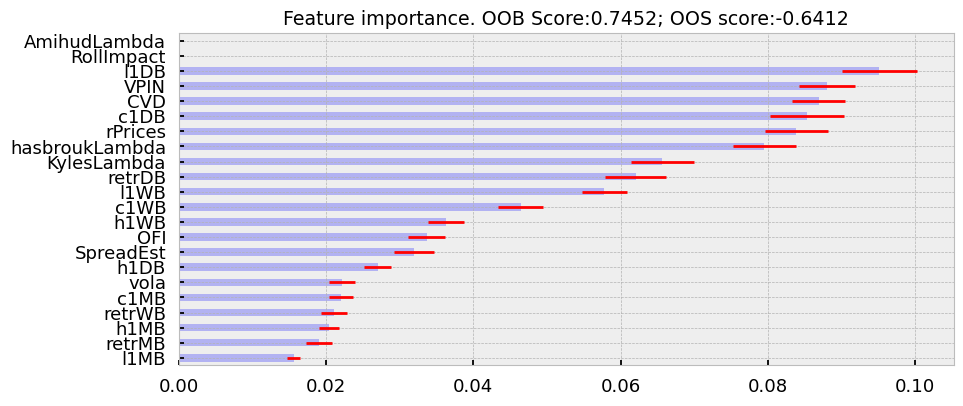

In [281]:
mdi=mean_decrease_impurity(clf2,X.columns)
plot_feature_importance(mdi,
oob_score=clf2.oob_score_,
oos_score=oos.mean(),
)

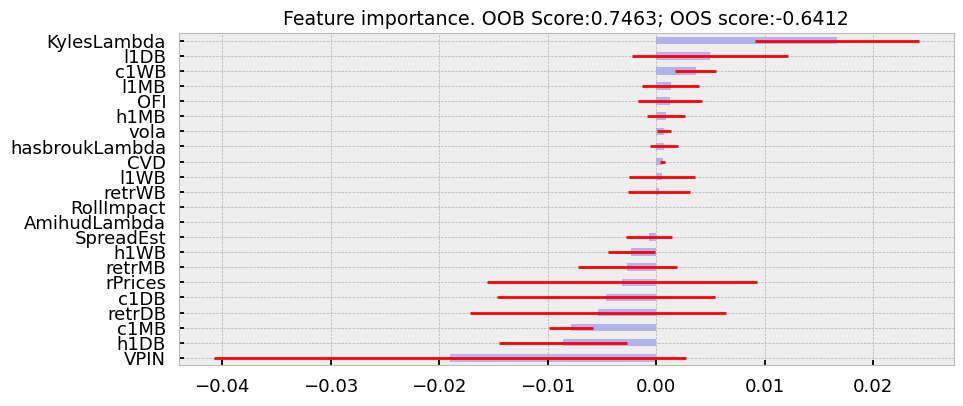

In [282]:
mda=mean_decrease_accuracy(clf2,X.loc[idx],y.loc[idx],cv_gen,sample_weight_train=w.loc[idx],scoring=log_loss)
plot_feature_importance(mda,
oob_score=clf2.oob_score_,
oos_score=oos.mean(),
)